# Segmenting and Clustering Neighborhoods in Toronto

## Table of Contents


<br>
<font size = 3>

1.  <a href="#item1">WebScraping Results</a>

2.  <a href="#item2">Plot of the selected neighborhoods in Toronto for the analysis</a>

3.  <a href="#item3"> Map to visualize Clustered neighborhoods</a> 
    </font>
    </div>

### Set up
Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import json # library to handle JSON files
import requests # library to handle requests

from bs4 import BeautifulSoup # webscraping

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans # clustering
import folium # map rendering library

### WebScraping
Creating a table with the content of an specific page from wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #wikipedia webpage's URL
html_data = requests.get(url).text

In [3]:
soup = BeautifulSoup(html_data,"html5lib") # webscraping set up
tables = soup.find_all('table')

In [4]:
#creating a iterative FOR to fullfill by webscraping the table columns: PostalCode, Borough, Neighborhood 
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [5]:
#transforming the list in a dataframe with some datacare replacement
df_toronto=pd.DataFrame(table_contents)
df_toronto['Borough']=df_toronto['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
# printing the first results of the dataframe
df_toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Importing data from an provided CSV
In order to aggregate geocoordinates to df_toronto was used a .csv file

In [7]:
# creating an auxiliary dataframe based on a CSV with geocoordinates
folder = '/Users/thiagocarvalho/Documents/databases/'
geo_toronto = pd.read_csv(folder+'Geospatial_Coordinates.csv')
geo_toronto.rename(columns={'Postal Code': 'PostalCode'}, inplace = True) #key column renaming for enabling the merge
geo_toronto.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<a id='item1'></a>

### Webscraping results

In [8]:
# Updating the main dataframe adding geocoordinates
df_toronto = pd.merge(df_toronto, geo_toronto, how="inner", on=["PostalCode"])
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Exploring and clustering the neighborhoods in Toronto.

### a) Reducing the dataframe and plotting it in a map

In [9]:
# Selecting the Borough tha within its name contains "Toronto" --> for the sake of simplicity
df_toronto_filtered = df_toronto[(df_toronto['Borough'].str.contains("Toronto"))].reset_index(drop=True)
df_toronto_filtered

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106


In [11]:
# Full and filtered dataframe size comparison

print('The original dataframe has {} boroughs and {} neighborhoods.'.format(\
        len(df_toronto['Borough'].unique()),df_toronto.shape[0]))
print('And the filtered dataframe has {} boroughs and {} neighborhoods.'.format(\
        len(df_toronto_filtered ['Borough'].unique()),df_toronto_filtered.shape[0]))

The original dataframe has 14 boroughs and 103 neighborhoods.
And the filtered dataframe has 6 boroughs and 39 neighborhoods.


In [13]:
# Getting the geographical coordinates of Downtown Toronto.

address = 'Downtown Toronto, Toronto, Ontario'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geocoordenates of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geocoordenates of Downtown Toronto are 43.6563221, -79.3809161.


<a id='item2'></a>

#### Plot of the selected neighborhoods in Toronto for the analysis

In [15]:
# Creating map of Downtown selected Boroughs(with Toronto in the name) using latitude and longitude values
map_filtered_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_toronto_filtered['Latitude'], df_toronto_filtered['Longitude'], df_toronto_filtered['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_filtered_toronto)  
    
map_filtered_toronto

#### Extracting the data and storing it into a dataframe 

In [16]:
#### Setting Foursquare Credentials and Version
CLIENT_ID = 'NEY31EWLA20BXGLRP4TEJKOZ2BHRW4IHSZDSXRRJTEO4DL5S' # your Foursquare ID
CLIENT_SECRET = 'OEFPZLW11ZSW03TMMCC2JX2U0KI5AUANNR4G2LNSZNF0VIXR' # your Foursquare Secret
ACCESS_TOKEN = '4E5F2L0KN00FDXI5W5AXLDBNUGAGKVBE2EW5CZB1L3D1LUSA' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [17]:
#### Estabilishing a function to get top 100 venues of
#### all the neighborhoods in Downtown Toronto within a radius of 500 meters

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Extracting data using the API and stablished function

In [18]:
downtown_toronto_venues = getNearbyVenues(names=df_toronto_filtered['Neighborhood'],
                                   latitudes=df_toronto_filtered['Latitude'],
                                   longitudes=df_toronto_filtered['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [19]:
# Checking the dataframe with the extraction results 
print(downtown_toronto_venues.shape)
downtown_toronto_venues.head()

(1577, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [20]:
downtown_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,66,66,66,66,66,66
Christie,16,16,16,16,16,16
Church and Wellesley,74,74,74,74,74,74
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37
Davisville North,8,8,8,8,8,8


In [21]:
print('There are {} uniques categories.'.format(len(downtown_toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


### b) Analyzing neighborhoods one by one

In [22]:
# one hot encoding
downtown_toronto_onehot = pd.get_dummies(downtown_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_toronto_onehot['Neighborhood'] = downtown_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_toronto_onehot.columns[-1]] + list(downtown_toronto_onehot.columns[:-1])
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]

downtown_toronto_onehot.shape

(1577, 233)

In [23]:
# Examining the new dataframe
downtown_toronto_onehot.describe()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
count,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,...,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000
mean,0.006975,0.000634,0.000634,0.000634,0.000634,0.000634,0.001268,0.010146,0.001902,0.003171,...,0.000634,0.000634,0.002536,0.001902,0.010146,0.001268,0.004439,0.005707,0.000634,0.000634
std,0.083253,0.025182,0.025182,0.025182,0.025182,0.025182,0.035601,0.100246,0.043588,0.056236,...,0.025182,0.025182,0.050315,0.043588,0.100246,0.035601,0.066497,0.075353,0.025182,0.025182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category
downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighborhood').mean().reset_index()
downtown_toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.066667,0.066667,0.066667,0.066667,0.066667,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Central Bay Street,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.015152,0.0,0.0
4,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


#### Putting the top 10 venues of each neighborhood results into a _pandas_ dataframe

In [25]:
# Using a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_toronto_grouped['Neighborhood']

for ind in np.arange(downtown_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Cheese Shop,Pharmacy,Eastern European Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry,Airport Gate
3,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Restaurant,Ramen Restaurant,Portuguese Restaurant
4,Christie,Grocery Store,Café,Park,Nightclub,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store,Restaurant,Coffee Shop


### c) Clustering Downtown Toronto's Neighborhoods

### k_-means to cluster the neighborhood into 3 clusters according to Elbow Method.

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

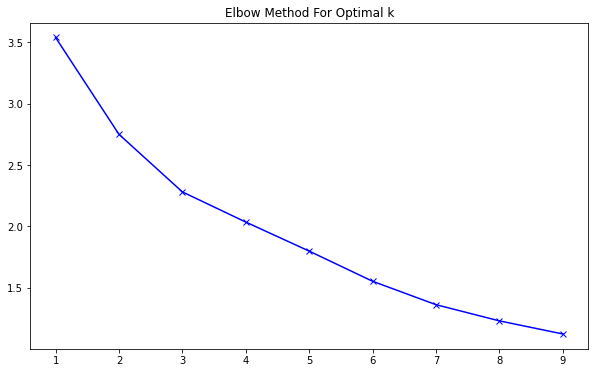

In [63]:
sum_of_squared_distances = []
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(downtown_toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [69]:
# set number of clusters
kclusters = 3

downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Creating a new dataframe that includes the cluster + top 10 venues for each neighborhood + the neiborhood geocoordenates.

In [70]:
# adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_toronto_merged = df_toronto_filtered

# merging neighborhoods_venues_sorted with df_downtown_toronto to add latitude/longitude for each neighborhood
downtown_toronto_merged = downtown_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_toronto_merged.head() # checking the first columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Café,Pub,Park,Breakfast Spot,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Electronics Store,Italian Restaurant,Burger Joint
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Beer Bar,Cocktail Bar,Cosmetics Shop,Gastropub,Hotel,Park,Gym,Italian Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Wings Joint,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Cheese Shop,Pharmacy,Eastern European Restaurant


<a id='item3'></a>

#### Map to visualize Clustered neighborhoods

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'], downtown_toronto_merged['Neighborhood'], downtown_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [73]:
#Examining cluster 1
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 0, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Bakery,Café,Pub,Park,Breakfast Spot,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Electronics Store,Italian Restaurant,Burger Joint
2,Downtown Toronto,0,Café,Coffee Shop,Beer Bar,Cocktail Bar,Cosmetics Shop,Gastropub,Hotel,Park,Gym,Italian Restaurant
3,East Toronto,0,Health Food Store,Trail,Pub,Wings Joint,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
4,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Beer Bar,Farmers Market,Restaurant,Cheese Shop,Pharmacy,Eastern European Restaurant
5,Downtown Toronto,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Restaurant,Ramen Restaurant,Portuguese Restaurant
6,Downtown Toronto,0,Grocery Store,Café,Park,Nightclub,Italian Restaurant,Baby Store,Athletics & Sports,Candy Store,Restaurant,Coffee Shop
7,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Deli / Bodega,Gym,Clothing Store,Thai Restaurant,Concert Hall,Salad Place,Hotel
8,West Toronto,0,Pharmacy,Bakery,Middle Eastern Restaurant,Music Venue,Park,Café,Brewery,Bar,Bank,Supermarket
10,Downtown Toronto,0,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Sporting Goods Shop,Scenic Lookout,Italian Restaurant,Restaurant,Brewery


In [74]:
#Examining cluster 2
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 1, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Playground,Restaurant,Wings Joint,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [75]:
#Examining cluster 3
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 2, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,2,Park,Convenience Store,Wings Joint,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
18,Central Toronto,2,Bus Line,Park,Swim School,Wings Joint,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
33,Downtown Toronto,2,Park,Playground,Trail,Wings Joint,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
